In [42]:
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import codecs
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import csv
import string
from datetime import datetime
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import   RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
# --------------------------------------- #
import pyarabic.araby as araby
import pyarabic.number as number
from pyarabic.araby import strip_tashkeel
from pyarabic.araby import strip_tatweel
from pyarabic.araby import tokenize, is_arabicrange, strip_tashkeel
# --------------------------------------- #
import pyarabic.arabrepr
arepr = pyarabic.arabrepr.ArabicRepr()
repr = arepr.repr
from tashaphyne.stemming import ArabicLightStemmer
import emoji



import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/nadaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
# load dataset
df = pd.read_csv('/Users/nadaa/Desktop/Osama/final_one.csv')
df1 = pd.read_csv('/Users/nadaa/Downloads/Negitive_ready_half-1.csv')
df2 = pd.read_csv('/Users/nadaa/Downloads/Neutral_ready_half.csv')
df3 = pd.read_csv('/Users/nadaa/Downloads/Positive_ready_half.csv')

In [44]:
new = df.copy()
new2 = df1.copy()
new3 = df2.copy()
new4 = df3.copy()

new1 = new[['screen_name','text','sentiment']]
nnew1 = new2[['screen_name','text','sentiment']]
neew1 = new3[['screen_name','text','sentiment']]
neww1 = new4[['screen_name','text','sentiment']]

merged_df = pd.concat([nnew1, neew1])
merged_df1 = pd.concat([neww1, merged_df])
data = pd.concat([new1, merged_df1])

data.head()

,screen_name,text,sentiment
0,M_World2020,RT @M_World2020: https://t.co/nyyt4s0bsG\n#بلا...,Negative
1,B7Kgsvd72R2jzNL,RT @taqa_sa: جمعنا لكم أهم النصائح للتقليل من ...,Positive
2,Abohedab1,RT @taqa_sa: الجار قبل الدار والأخضر قبل الأحم...,Positive
3,Hanoma29441020,RT @taqa_sa: جمعنا لكم أهم النصائح للتقليل من ...,Positive
4,560Mohammad,RT @M_World2020: https://t.co/nyyt4s0bsG\n#بلا...,Negative


In [45]:
# Reset the index of dataframe
newdata = data.reset_index()
newdata["id"] = newdata.index 

newdata

,index,screen_name,text,sentiment,id
0,0,M_World2020,RT @M_World2020: https://t.co/nyyt4s0bsG\n#بلا...,Negative,0
1,1,B7Kgsvd72R2jzNL,RT @taqa_sa: جمعنا لكم أهم النصائح للتقليل من ...,Positive,1
2,2,Abohedab1,RT @taqa_sa: الجار قبل الدار والأخضر قبل الأحم...,Positive,2
3,3,Hanoma29441020,RT @taqa_sa: جمعنا لكم أهم النصائح للتقليل من ...,Positive,3
4,4,560Mohammad,RT @M_World2020: https://t.co/nyyt4s0bsG\n#بلا...,Negative,4
...,...,...,...,...,...
20982,4965,bobo19492011,اذا صار في موتري شي ماعرف الا انت,Neutral,20982
20983,4966,sal7nd,هذا نصراوي النصراوي عمله الصياح ليل نهار...,Neutral,20983
20984,4967,abomohammad1900,اشكرك,Neutral,20984
20985,4968,hbomlg57,ههههه ايه بدون رخص صحيح اللي شفته يمشي ع...,Neutral,20985


In [46]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

# def space(text):
#     text= re.sub(r"_", '\s+', s)
#     return text

# new1['text'].replace('_', ' ', regex=True, inplace=True)


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_hashtag(text):
    return text.replace("#\\p{IsAlphabetic}+", "");

In [47]:
def processPost(tweet):

    #Replace @username with empty string
    tweet = re.sub('@[^\s]+', ' ', tweet)
    
    #Replace RT with empty string
    tweet = re.sub('RT', ' ', tweet)
    
    #Convert www.* or https?://* to " "
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    
    #remove non-arabic
#      tweet = re.sub(r'[^ء-ي0-9]',' ',tweet)

    return tweet

In [48]:
newdata['text'].replace('[^ء-ي0-9]', ' ', regex=True, inplace=True)

newdata['text'].replace('_', ' ', regex=True, inplace=True)

newdata['text'] = newdata['text'].str.replace(r'\d+','')

newdata['text']= newdata['text'].apply(lambda x: remove_diacritics(x))

newdata['text']= newdata['text'].apply(lambda x: remove_repeating_char(x))

newdata['text']= newdata['text'].apply(lambda x: processPost(x))

newdata['text']= newdata['text'].apply(lambda x: remove_hashtag(x))

newdata['text']= newdata['text'].apply(lambda x: remove_punctuations(x))

newdata['text']= newdata['text'].apply(lambda x: remove_repeating_char(x))

In [49]:
tokens = TweetTokenizer()
newdata['text'] = newdata['text'].apply(tokens.tokenize)

newdata.head(10)

,index,screen_name,text,sentiment,id
0,0,M_World2020,"[بلاك, فرايدي, شي, إن, جامعة, الحفر, عن, بعد, ...",Negative,0
1,1,B7Kgsvd72R2jzNL,"[جمعنا, لكم, أهم, النصائح, لتقليل, من, استهلاك...",Positive,1
2,2,Abohedab1,"[الجار, قبل, الدار, والأخضر, قبل, الأحمر, وفرت...",Positive,2
3,3,Hanoma29441020,"[جمعنا, لكم, أهم, النصائح, لتقليل, من, استهلاك...",Positive,3
4,4,560Mohammad,"[بلاك, فرايدي, شي, إن, جامعة, الحفر, عن, بعد, ...",Negative,4
5,5,M_World2020,"[بلاك, فرايدي, شي, إن, جامعة, الحفر, عن, بعد, ...",Negative,5
6,6,xx3b00,"[جمعنا, لكم, أهم, النصائح, لتقليل, من, استهلاك...",Positive,6
7,7,KASUMI30823210,"[لمبات, الدرج, والمرات, تشتغل, على, طول, وبدون...",Positive,7
8,8,ktkf9559,"[وف, ر, أكثر, وأكثر, باختيار, الأخضر, وفرت, وأ...",Positive,8
9,9,Kaashlal60,"[دايم, نقول, الأخضر, أوفر, لكن, كم, يوفر, أكثر...",Positive,9


In [50]:
stop = ['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين','و', 'بيد',
         'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك',
         'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما',
         'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك',
         'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا',
         'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا',
         'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير',
         'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها',
         'قد', 'كأن', 'كأنما', 'كأي', 'كأين', 'كذا', 'كذلك', 'كل', 'كلا',
         'كلاهما', 'كلتا', 'كلما', 'كليكما', 'كليهما', 'كم', 'كم', 'كما',
         'كي', 'كيت', 'كيف', 'كيفما', 'لا', 'لاسيما', 'لدى', 'لست', 'لستم',
         'لستما', 'لستن', 'لسن', 'لسنا', 'لعل', 'لك', 'لكم', 'لكما',
         'لكن', 'لكنما', 'لكي', 'لكيلا', 'لم', 'لما', 'لن', 'لنا',
         'له', 'لها', 'لهم', 'لهما', 'لهن', 'لو', 'لولا', 'لوما',
         'لي', 'لئن', 'ليت', 'ليس', 'ليسا', 'ليست', 'ليستا', 'ليسوا', 'ما',
         'ماذا', 'متى', 'مذ', 'مع', 'مما', 'ممن', 'من', 'منه', 'منها', 'منذ',
         'مه', 'مهما', 'نحن', 'نحو', 'نعم', 'ها', 'هاتان', 'هاته', 'هاتي',
         'هاتين', 'هاك', 'هاهنا', 'هذا', 'هذان', 'هذه', 'هذي', 'هذين', 'هكذا',
         'هل', 'هلا', 'هم', 'هما', 'هن', 'هنا', 'هناك', 'هنالك', 'هو', 'هؤلاء',
         'هي', 'هيا', 'هيت', 'هيهات', 'والذي', 'والذين', 'وإذ', 'وإذا', 'وإن',
         'ولا', 'ولكن', 'ولو', 'وما', 'ومن', 'وهو', 'يا' , 'من' , 'على', 'الى','هما', 'مع', 'هذه', 'التي', 'كما ', 'ذلك ', 'لذا', 'عن', 'في','ان','كان','كانت','الى','قبل','أنه','تم'
        ,'وقال','قال','فى','وقد','قد','ولم','وذلك','ذلك','يكون','او','وهذه','وهي ','وبعد','وهذا','عندها','جدا','بأن','انه','الي']

In [51]:
newdata['text'] = [w for w in newdata['text'] if not w in stop]
newdata.head()

,index,screen_name,text,sentiment,id
0,0,M_World2020,"[بلاك, فرايدي, شي, إن, جامعة, الحفر, عن, بعد, ...",Negative,0
1,1,B7Kgsvd72R2jzNL,"[جمعنا, لكم, أهم, النصائح, لتقليل, من, استهلاك...",Positive,1
2,2,Abohedab1,"[الجار, قبل, الدار, والأخضر, قبل, الأحمر, وفرت...",Positive,2
3,3,Hanoma29441020,"[جمعنا, لكم, أهم, النصائح, لتقليل, من, استهلاك...",Positive,3
4,4,560Mohammad,"[بلاك, فرايدي, شي, إن, جامعة, الحفر, عن, بعد, ...",Negative,4


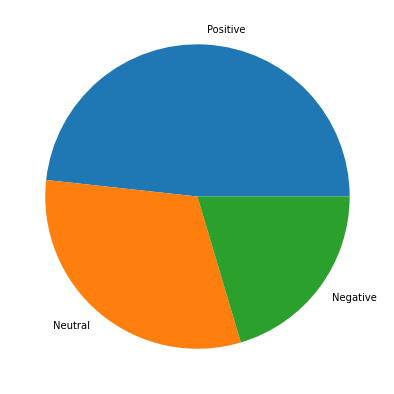

In [52]:
import matplotlib.pyplot as plt
y = newdata['sentiment'].value_counts()
x = ['Positive', 'Neutral', 'Negative']
ig = plt.figure(figsize =(10, 7)) 
plt.pie(y, labels = x) 
# show plot 
plt.show()

# Model

### vectorizer

In [53]:
y = newdata['text'].apply(lambda x: ' '.join(x))
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stop)
X = vectorizer.fit_transform(y).toarray()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['وهي'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### TF-IDF

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
Y = newdata.sentiment

### Split data to train and test

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Build Model

# GaussianNB

In [56]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print (accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions)

0.6793711291090996


In [57]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,gnb_predictions))
print(classification_report(y_test,gnb_predictions))
print(accuracy_score(y_test, gnb_predictions))

[[ 799   34   29]
 [ 799  429  113]
 [ 299   72 1624]]
              precision    recall  f1-score   support

    Negative       0.42      0.93      0.58       862
     Neutral       0.80      0.32      0.46      1341
    Positive       0.92      0.81      0.86      1995

    accuracy                           0.68      4198
   macro avg       0.71      0.69      0.63      4198
weighted avg       0.78      0.68      0.68      4198

0.6793711291090996


# Saving and Loading the Model

### Save model

In [58]:
import pickle
with open('GaussianNB', 'wb') as picklefile:
    pickle.dump(gnb,picklefile)

### Lode model

In [59]:
import pickle
with open('GaussianNB', 'rb') as training_model:
    taqa1 = pickle.load(training_model)

#### Test from file

In [61]:
newdata['predictions'] = taqa1.predict(X)
#Or newdata['predictions'] = pd.DataFrame(Predictions) - if Length of values does not match length of index
newdata.head()

,index,screen_name,text,sentiment,id,predictions
0,0,M_World2020,"[بلاك, فرايدي, شي, إن, جامعة, الحفر, عن, بعد, ...",Negative,0,Negative
1,1,B7Kgsvd72R2jzNL,"[جمعنا, لكم, أهم, النصائح, لتقليل, من, استهلاك...",Positive,1,Positive
2,2,Abohedab1,"[الجار, قبل, الدار, والأخضر, قبل, الأحمر, وفرت...",Positive,2,Positive
3,3,Hanoma29441020,"[جمعنا, لكم, أهم, النصائح, لتقليل, من, استهلاك...",Positive,3,Positive
4,4,560Mohammad,"[بلاك, فرايدي, شي, إن, جامعة, الحفر, عن, بعد, ...",Negative,4,Negative
